In [1]:
import requests

# GitHub API URL for commits in the google/guava repo
url = "https://api.github.com/repos/google/guava/commits"

headers = {
    "Accept": "application/vnd.github+json",
}

response = requests.get(url, headers=headers)

data = {"date": [], "message": [], "author": []}

if response.status_code == 200:
    commits = response.json()
    for commit in commits:
        sha = commit['sha']
        message = commit['commit']['message']
        author = commit['commit']['author']['name']
        date = commit['commit']['author']['date']
        data["date"].append(date)
        data["author"].append(author)
        data["message"].append(message)
else:
    print(f"Failed to fetch commits: {response.status_code} - {response.text}")


In [21]:
import requests
import pandas as pd

def get_commits(owner: str, repo: str, branch: str = None, per_page: int = 30, page: int = 1, token: str = None):
    url = f"https://api.github.com/repos/{owner}/{repo}/commits"
    headers = {
        "Accept": "application/vnd.github+json"
    }
    if token:
        headers["Authorization"] = f"Bearer {token}"
    params = {
        "per_page": per_page,
        "page": page
    }
    if branch:
        params["sha"] = branch

    resp = requests.get(url, headers=headers, params=params)
    resp.raise_for_status()
    return resp.json()

def get_all_commits(OWNER, REPO):
    result = {"author": [], "date": [], "message": []}
    i = 0
    while True:
        print(f"iter {i}")
        commits = get_commits(OWNER, REPO, branch="main", per_page=100, page=1, token=None)
        if not commits:
            break
        for c in commits:
            commit_info = c.get("commit", {})
            author = commit_info.get("author", {}).get("name")
            date = commit_info.get("author", {}).get("date")
            message = commit_info.get("message")
            result["author"].append(author)
            result["date"].append(date)
            result["message"].append(message)
            i += 1
    return pd.DataFrame(result)


OWNER = "pytorch"
REPO = "pytorch"
commits = get_all_commits(OWNER,REPO)
print(commits)


iter 0


HTTPError: 403 Client Error: rate limit exceeded for url: https://api.github.com/repos/pytorch/pytorch/commits?per_page=100&page=1&sha=main

# GIT LOG

In [5]:
import calendar
from datetime import datetime
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
result = {"author": [], "date": [], "message": []}
with open("repo/xnn_git_history.txt", "r", encoding="utf-16") as fp:
    result = {"author": [], "date": [], "sha": []}
    for line in fp.readlines():
        if line.startswith("commit"):
            _, sha = line.split(maxsplit=1)
            result["sha"].append(sha.strip())
        elif line.startswith("Author"):
            _, author = line.split(maxsplit=1)
            result["author"].append(author.strip())
        elif line.startswith("Date"):
            _, date = line.split(maxsplit=1)
            result["date"].append(date.strip())

df = pd.DataFrame(result)
df["date"] = df["date"].map(lambda d : datetime.strptime(d, "%a %b %d %H:%M:%S %Y %z"))
df = df.sort_values("date")
df["count"] = np.arange(1, len(df)+1)
df.head()

,author,date,sha,count
8608,XNNPACK Team <xnnpack-github-robot@google.com>,2019-09-27 18:10:33-07:00,b455b1209fc0f28eef8ef647fcd4425705363bcf,1
8607,Marat Dukhan <maratek@google.com>,2019-09-29 21:06:36-07:00,80fc932f1d9400051f0b4306fadd9ee3369fc727,2
8606,Frank Barchard <fbarchard@google.com>,2019-09-30 11:05:52-07:00,bb4c18b433764db0a3bcc0baa0d7bc41f2df97ec,3
8605,Frank Barchard <fbarchard@google.com>,2019-09-30 16:21:55-07:00,4c2637da4b0a1df58bb30e8ef24b182fc3065fb7,4
8604,Marat Dukhan <maratek@google.com>,2019-10-01 10:39:14-07:00,629a33eef8ef2fa86764a16da85a4770f3898953,5


<Axes: xlabel='date'>

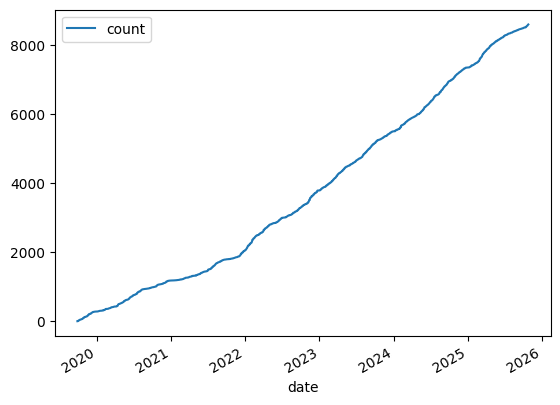

In [22]:
df.plot(x="date", y="count")


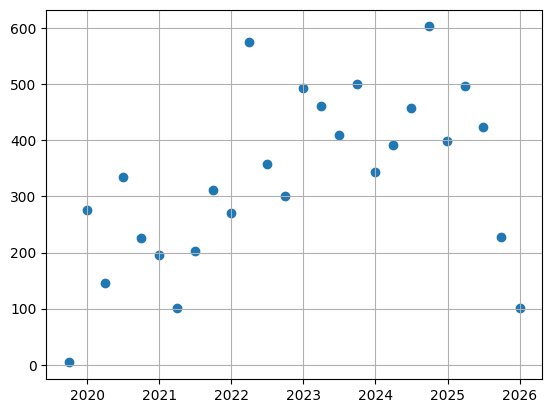

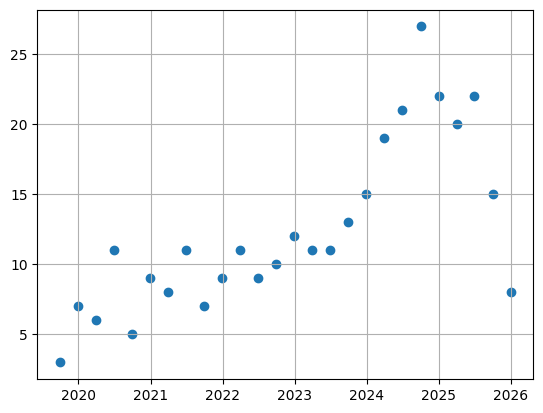

In [23]:
def to_querter(month):
    if month in [1,2,3]: return 1
    if month in [4,5,6]: return 2
    if month in [7, 8, 9]: return 3
    if month in [10, 11, 12]: return 4

def from_quarter(quarter):
    if quarter == 1: return [1, 2, 3]
    elif quarter == 2: return [4, 5, 6]
    elif quarter == 3: return [7, 8, 9]
    else: return [10, 11, 12]

def q2m_start(r):
    months = from_quarter(r.quarter)
    m = months[0]
    return datetime(r.year, m, 1)

def q2m_end(r):
    months = from_quarter(r.quarter)
    m = months[-1]
    days_in_month = calendar.monthrange(r.year, m)[1]
    return datetime(r.year, m, days_in_month)

df["month"] = df["date"].apply(lambda d : d.month)
df["year"] = df["date"].apply(lambda d : d.year)
df["quarter"] = df["date"].apply(lambda d : to_querter(d.month))
commits_num = df.groupby(by=["year", "quarter"])["author"].count().rename("commit_count").reset_index()
labour_num = df.groupby(by=["year", "quarter", "author"])["date"].count().rename("labour_count").reset_index()
labour_num = labour_num.groupby(by=["year", "quarter"])["author"].count().rename("labour_count").reset_index()

labour_num["quarter_start"] = labour_num[["year", "quarter"]].apply(q2m_start, axis=1)
labour_num["quarter_end"] = labour_num[["year", "quarter"]].apply(q2m_end, axis=1)
commits_num["quarter_start"] = commits_num[["year", "quarter"]].apply(q2m_start, axis=1)
commits_num["quarter_end"] = commits_num[["year", "quarter"]].apply(q2m_end, axis=1)

plt.scatter(commits_num["quarter_end"], commits_num["commit_count"])
plt.grid()
plt.show()
plt.scatter(labour_num["quarter_end"], labour_num["labour_count"])
plt.grid()

In [ ]:
plt.scatter(commits_num["quarter_end"], commits_num["commit_count"])

In [ ]:
df.groupby(by=["year", "quarter"])["commits"].count()

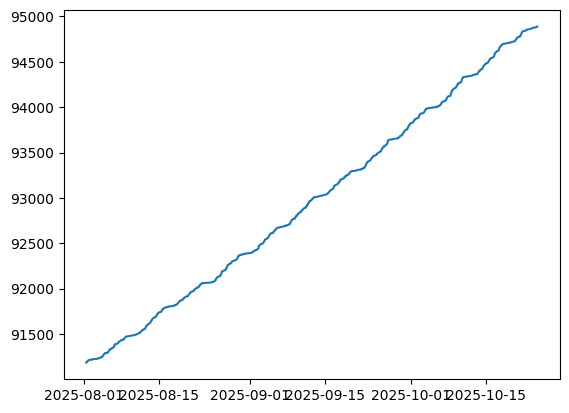

In [75]:
d = "2025-08-01 16:54:41+01:00"	
target = pd.to_datetime(d)	
filtered = df[df["date"] > target]
plt.plot(filtered["date"], filtered["count"])